In [ ]:
import os
import noisereduce as nr  
from pathlib import Path
import torchaudio
import torch
import numpy as np

In [ ]:

filedirpath = Path("./wav/").resolve()
outdirpath = Path("./stage1/").resolve()

filenames = sorted(os.listdir(filedirpath))

for filename in filenames:
    filepath = filedirpath.joinpath(filename)

    data, fs = torchaudio.load(str(filepath))
    data_np = np.mean(data.numpy(), axis=0)
    data_np = data_np / np.max(data_np)
    resampled = torchaudio.functional.resample(torch.from_numpy(data_np)[None, :], fs, 32000)
    torchaudio.save(outdirpath.joinpath(filename), resampled, 32000)

In [ ]:
indir = Path('./resampled/')
outdir = Path('./chunks/')

SR = 32000
SECONDS_PER_SAMPLE = 30

# for classname in classnames:
# classdir = indir.joinpath(classname)

classdata = torch.tensor([], dtype=torch.float32)
filenames = sorted(os.listdir(indir))

current_class = None
outi = 0
for filename in filenames:
    classname = filename[:filename.index('-', filename.index('-') + 1)]
    
    if current_class != classname:
        if current_class is not None:
            chunks = torch.split(classdata, split_size_or_sections=SR*SECONDS_PER_SAMPLE, dim=1)[:-1]
            for chunk in chunks:
                outpath = outdir.joinpath(f'{current_class}_{outi}.wav')
                torchaudio.save(str(outpath), chunk, SR)
                outi += 1

        outi = 0
        current_class = classname
    
    data, sr = torchaudio.load(str(indir.joinpath(filename)))
    assert(sr == SR)
    assert(data.dtype == torch.float32)
    chunks = torch.split(data, split_size_or_sections=SR*SECONDS_PER_SAMPLE, dim=1)

    for chunk in chunks[:-1]:
        outpath = outdir.joinpath(f'{current_class}_{outi}.wav')
        torchaudio.save(str(outpath), chunk, SR)
        outi += 1
    
    classdata = torch.cat((classdata, chunks[-1]), dim=1)



In [ ]:
n_fft = 2048
hop_length = n_fft // 4

fig, ax = plt.subplots(2, 1)

data = None # TODO

def myspecshow(data, ax):
    spec = np.abs(lr.stft(data, n_fft=n_fft, hop_length=hop_length))**2
    mspec = lr.feature.melspectrogram(sr=fs, S=spec)

    mspec = lr.power_to_db(mspec, ref=np.max)
    return mspec, specshow(mspec, sr=fs, y_axis='mel', x_axis='time', hop_length=hop_length, ax=ax)

data_np = np.mean(data.numpy(), axis=0)
print(data_np.shape)
data_np = data_np / np.max(data_np)
data_filt = nr.reduce_noise(data_np, fs)
torchaudio.save('filtered.wav', torch.from_numpy(data_filt[None, :]), fs)

spec, img = myspecshow(data_filt, ax[0])
fig.colorbar(img, ax=ax, format="%+2.f dB")

o_env = lr.onset.onset_strength(sr=fs, S=spec)
times = lr.times_like(o_env, sr=fs)
onsets = lr.onset.onset_detect(onset_envelope=o_env, sr=fs)
print(onsets[:10])


ax[1].vlines(times[onsets], 0, o_env.max(), color='r', alpha=0.9)
ax[1].plot(times, o_env)
ax[1].set_xlim(times[0], times[-1])



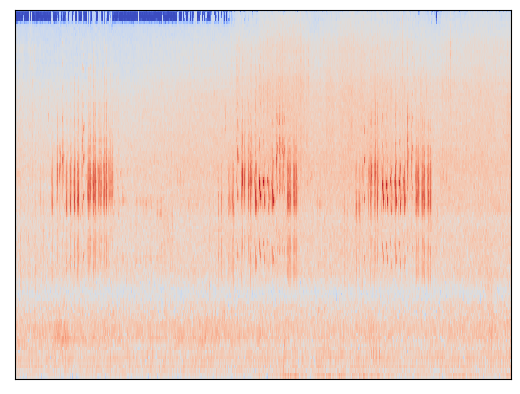

In [5]:
import torchaudio
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
import pytorch_lightning as pl
from torchinfo import summary
# from torch.utils.data.dataset import random_split
import torch
from torch import nn, optim
from torch.utils.data.dataloader import MapDataPipe, DataLoader
from torch.utils.data.dataset import random_split
from pathlib import Path
import os

SR = 32000
TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 100

class BirdsongDataset(MapDataPipe):
    def __init__(self, samplesdir: str) -> None:
        self.samplesdir = samplesdir
        self.filenames = sorted(os.listdir(samplesdir))

        class_names = set()

        for file in self.filenames:
            class_names.add(file[:file.index('_')])
        
        self.class_name_to_idx = {name: i for i, name in enumerate(sorted(list(class_names)))}

        super().__init__()

    def __getitem__(self, index):
        data, fs = torchaudio.load(f'{self.samplesdir}/{self.filenames[index]}')
        assert(fs == SR)
        filename = self.filenames[index]
        return data, self.class_name_to_idx[filename[:filename.index('_')]] #tensor, label
    
    def __len__(self):
        return len(self.filenames)

dataset = BirdsongDataset('chunks')
torch.manual_seed(0)
traindata, testdata= random_split(dataset, (0.8, 0.2))
traindata, valdata = random_split(traindata, (0.9, 0.1))

train_dataloader = DataLoader(traindata, batch_size=TRAIN_BATCH_SIZE, num_workers=12)
val_dataloader = DataLoader(valdata, batch_size=VAL_BATCH_SIZE, num_workers=12)
# test_dataloader = DataLoader(testdata, batch_size=BATCH_SIZE)

sample_batch = torch.cat([dataset[i][0][None, :] for i in range(TRAIN_BATCH_SIZE)], dim=0)

process = nn.Sequential(
    MelSpectrogram(sample_rate=SR, n_fft=1024),
    AmplitudeToDB(),
)


from librosa.display import specshow
data = process(sample_batch[0])[0].numpy()
specshow(data)